In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import torchvision
import numpy as np
from PIL import Image
import os
from glob import glob
import cv2

In [3]:
image_dir = 'DanishTeam_Segmentation/Training/imgs/'
mask_dir = 'DanishTeam_Segmentation/Training/masks/'

In [4]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, image_dir, mask_dir, mask_suffix='', transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.mask_suffix = mask_suffix

    if transform == None:
      self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    else: 
      self.transform = transform
    self.ids = [os.path.splitext(file)[0] for file in os.listdir(image_dir)
                    if not file.startswith('.') and not '20210305' in file]

  def __getitem__(self, i):
    basename = self.ids[i]

    mask_file = glob(self.mask_dir + basename + self.mask_suffix + '.*')
    img_file = glob(self.image_dir + basename + '.*')

    mask = cv2.imread(mask_file[0])
    img = cv2.imread(img_file[0]) 

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = self.transform(img)
    mask = self.transform(mask)
    base_array = torch.zeros_like(mask[0])
    base_array[mask[0] > 0.] = 1  
    base_array = base_array.reshape(1, base_array.shape[0], base_array.shape[1])

    return img, base_array

  def __len__(self):
    return len(self.ids)

In [5]:
dataset = CustomDataset(image_dir, mask_dir)

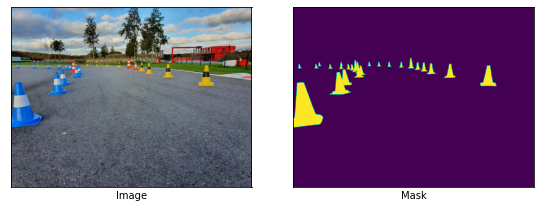

In [6]:
import matplotlib.pyplot as plt

def plot_class_masks(item: np.ndarray) -> None:
    """Plot a particular view of the true vs predicted segmentation.

    This function separates each class into its own image and
    does not perform any thresholding.

    Parameters:
        y_true: True segmentation (image_shape, num_classes).
        y_predicted: Predicted segmentation (image_shape, num_classes).
            If y_predicted is not provided, only the true values are displayed.
    """
    num_rows = 1

    num_columns = 2
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 4, num_rows * 4))
    axes = axes.reshape(-1, num_columns)
    plt.tight_layout()
    
    axes[0, 0].imshow(item[0].squeeze().permute(1,2,0))
    axes[0, 0].set_xlabel("Image")
    axes[0, 0].axes.set_xticks([])
    axes[0, 0].axes.set_yticks([])
    axes[0, 1].imshow(item[1].squeeze())
    axes[0, 1].set_xlabel("Mask")
    axes[0, 1].axes.set_xticks([])
    axes[0, 1].axes.set_yticks([])

    plt.show()

plot_class_masks(dataset[100])

In [16]:
tsplit = 0.15
tsize = int(len(dataset)*tsplit)
indices = torch.randperm(len(dataset)).tolist()

train = torch.utils.data.Subset(dataset, indices[:-tsize])
test = torch.utils.data.Subset(dataset, indices[-tsize:])

train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=10,
  shuffle=True,
  num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=10,
    shuffle=True,
    num_workers=0
)

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn

class CNN(nn.Module):
    LAYERS = ["15", "30", "M", "60", "60", "60", "M", "120", "120"]

    
    def __init__(self, output_dim=1):
        super().__init__()
        self.features = []
        in_channels = 3
        
        # Encoder
        for layer in self.LAYERS:
            if layer == "M":
                self.features.append(nn.MaxPool2d(kernel_size=(2,2), stride=2))
            else:
                self.features.append(qnn.QuantConv2d(in_channels, int(layer), weight_bit_width=3, kernel_size=3, stride=1, padding=1, groups=3))
                self.features.append(nn.ReLU6())
                in_channels = int(layer)
        
        self.features.append(qnn.QuantConv2d(int(self.LAYERS[-1]), int(self.LAYERS[-1]), weight_bit_width=3, kernel_size=(1,1), stride=1, padding=0, groups=3))
        self.features.append(qnn.QuantConvTranspose2d(int(self.LAYERS[-1]), 64, weight_bit_width=3, kernel_size=(4, 4), stride=2, padding=1))
        self.features.append(qnn.QuantConvTranspose2d(64, 32, weight_bit_width=3, kernel_size=(4, 4), stride=2, padding=1))
        
        self.features.append(qnn.QuantConvTranspose2d(32, output_dim, weight_bit_width=3, kernel_size=(3, 3), stride=1, padding=1))
        
        self.conv = nn.Sequential(*self.features)
        
        self.sigmoid = torch.sigmoid
    
    def forward(self, x):

        x = self.conv(x)
            
        x = self.sigmoid(x)
        
        return x

In [11]:
model = CNN(output_dim=1).double()
model(torch.rand((1, 3, 1088, 1456)).double())

tensor([[[[0.4525, 0.4246, 0.4115,  ..., 0.4233, 0.4107, 0.4423],
          [0.4789, 0.4567, 0.4381,  ..., 0.4441, 0.4417, 0.4516],
          [0.4670, 0.4486, 0.4488,  ..., 0.4516, 0.4474, 0.4526],
          ...,
          [0.4806, 0.4511, 0.4410,  ..., 0.4326, 0.4379, 0.4541],
          [0.4569, 0.4552, 0.4519,  ..., 0.4534, 0.4402, 0.4556],
          [0.5044, 0.4781, 0.4842,  ..., 0.4792, 0.4791, 0.4871]]]],
       dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [12]:
EPOCHS = 3
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
loss_func = nn.BCELoss()
print_every = 5
step = 0
test_losses, train_losses = [], []

In [17]:
for e in range(EPOCHS):
    running_loss = 0        
    for image, label in train_loader:
        step += 1
        optimizer.zero_grad()
        output = model(torch.tensor(image).double())
        loss = loss_func(output, torch.tensor(label))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0
            
            with torch.no_grad():
                model.eval()
                for image, label in test_loader:
                    output = model(torch.tensor(image).double())
                    test_loss += loss_func(output, torch.tensor(label))
                model.train()
                
                for g in optimizer.param_groups:
                    g['lr'] *= 0.95
                
                train_losses.append(running_loss/len(train_loader))
                test_losses.append(test_loss/len(test_loader))

                if not isinstance(checkpoint, bool): # checkpoint exists
                    if test_losses[-1] > test_losses[-2]*1.3:
                        model.load_state_dict(checkpoint)
                    else:
                        checkpoint = model.state_dict()
                else:
                    checkpoint = model.state_dict()
                
                print("Epoch: {}/{}.. ".format(e+1, EPOCHS),
                      "Training Loss: {:.3f}.. ".format(running_loss / print_every),
                      "Test Loss: {:.3f}.. ".format(test_losses[-1])) 
                
                running_loss = 0
                
print("Done Training...")

C:\Users\emran\AppData\Local\Temp/ipykernel_24988/2220543872.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image).double())


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5702860800 bytes.